## Predicting the outcome of a football match, based on historical match and player data.

This football matches dataset includes historical match outcomes, player statistics, and other relevant factors. The objective is to develop a multiclass classification model that accurately predicts the result of a football match: "home win", "away win", or "draw".

In [1]:
import gdown
import pandas as pd

url = 'https://drive.google.com/file/d/15R3R4O7CJdtnV8AhIDLYvtNoRtROf6dk/view?usp=sharing'

file_id = url.split('/')[-2]

download_url = f'https://drive.google.com/uc?id={file_id}'

output = 'downloaded_file.csv'
gdown.download(download_url, output, quiet=False)

df = pd.read_csv('downloaded_file.csv')

Downloading...
From: https://drive.google.com/uc?id=15R3R4O7CJdtnV8AhIDLYvtNoRtROf6dk
To: /Users/razan./KAUST-RzanAlmagoshi(1111367973)/downloaded_file.csv
100%|█████████████████████████████████████████| 122k/122k [00:00<00:00, 567kB/s]


In [2]:
# Imbalance
df['Score'].value_counts()
print("Imbalance: ", df['Score'].value_counts())
print("The data is slightly imbalanced !")

Imbalance:  Score
Home Win    164
Draw        135
Away win    113
Name: count, dtype: int64
The data is slightly imbalanced !


In [3]:
# Missing Values
NoOfMissingValues = df.isnull().sum()
print("Missing Values: ", NoOfMissingValues)

Missing Values:  Season                     0
Home Team                  0
Away Team                  0
Score                      0
Month                      0
Year                       0
WeekOfYear                 0
TotalShotsPerHomeTeam      0
TotalSoTPerHomeTeam        0
TotalPassesPerHomeTeam     0
TotalAccurPerHomeTeam      0
TotalInaccurPerHomeTeam    0
TotalShotsPerAwayTeam      0
TotalSoTPerAwayTeam        0
TotalPassesPerAwayTeam     0
TotalAccurPerAwayTeam      0
TotalInaccurPerAwayTeam    0
ShotsHomeAway_diff         0
SoTHomeAway_diff           0
TotalShotsPerMatch         0
TotalSoTPerMatch           0
TotalPassesPerMatch        0
TotalAccurPerMatch         0
TotalInaccurPerMatch       0
AccurPassesHome            0
AccurPassesAway            0
AccurPassesMatch           0
ShotsPerHalf1Home          0
ShotsPerHalf2Home          0
SoTPerHalf1Home            0
SoTPerHalf2Home            0
PassesPerHalf1Home         0
PassesPerHalf2Home         0
AccurPerHalf1Home         

In [4]:
# Duplicates
NoOfDuplicates = df.duplicated().sum()
print("Duplicates: ", NoOfDuplicates)

Duplicates:  0


In [5]:
# Categorical Values
CategoricalValues = df.select_dtypes(exclude=["number","bool_"])
print("Categorical Values: \n", CategoricalValues)

Categorical Values: 
          Home Team      Away Team     Score
0         Antennae      Andromeda  Away win
1        Andromeda       Antennae      Draw
2        Andromeda      Butterfly  Away win
3        Andromeda          Cigar  Away win
4        Andromeda       Circinus  Home Win
..             ...            ...       ...
407       Sculptor  Medusa Merger  Away win
408  Medusa Merger       Sculptor  Home Win
409  Medusa Merger       Sombrero  Home Win
410      Milky Way       Sculptor      Draw
411       Sculptor      Milky Way  Home Win

[412 rows x 3 columns]


In [6]:
df.head()

,Season,Home Team,Away Team,Score,Month,Year,WeekOfYear,TotalShotsPerHomeTeam,TotalSoTPerHomeTeam,TotalPassesPerHomeTeam,...,AccurPerHalf1Away,AccurPerHalf2Away,InaccurPerHalf1Away,InaccurPerHalf2Away,AccurPassesPerHalf1Away,AccurPassesPerHalf2Away,ShotsHalf1_diff,ShotsHalf2_diff,SoTHalf1_diff,SoTHalf2_diff
0,1,Antennae,Andromeda,Away win,2,2017,46,8.0,2.0,340.0,...,271.0,162.0,43.0,32.0,0.8633,0.8350,1.0,2.0,0.0,1.0
1,1,Andromeda,Antennae,Draw,9,2016,258,5.0,1.0,443.0,...,174.0,212.0,31.0,45.0,0.8486,0.8247,0.0,-5.0,0.0,1.0
2,1,Andromeda,Butterfly,Away win,12,2016,347,3.0,0.0,669.0,...,185.0,94.0,60.0,49.0,0.7550,0.6570,0.0,-3.0,-1.0,-1.0
3,1,Andromeda,Cigar,Away win,1,2017,25,5.0,2.0,384.0,...,174.0,179.0,46.0,47.0,0.7910,0.7920,-2.0,-4.0,-1.0,0.0
4,1,Andromeda,Circinus,Home Win,8,2016,237,13.0,2.0,542.0,...,237.0,215.0,55.0,59.0,0.8115,0.7847,4.0,4.0,0.0,2.0


Train and evaluate using K-Fold (K=5) without shuffling, and with F1 Score as the metric.

In [18]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

X = df.drop('Score', axis = 1)
y = df['Score'].map({
    "Home Win": 0,
    "Draw": 1,
    "Away win": 2
    })
print(y.head())

le = LabelEncoder()

X['Home Team'] = le.fit_transform(X['Home Team'])
X['Away Team'] = le.fit_transform(X['Away Team'])

X_scaled = StandardScaler().fit_transform(X)

0    2
1    1
2    2
3    2
4    0
Name: Score, dtype: int64


In [10]:
from sklearn.metrics import f1_score

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

fold_f1scores = []
Model = LogisticRegression(max_iter=500)  # Increase iterations
CV = KFold(n_splits=5, shuffle=False)

for train_index, test_index in CV.split(X_scaled, y):
    # Use direct indexing (no .iloc)
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]  
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # y is still a DataFrame, so use .iloc

    Model.fit(X_train, y_train)
    
    print(Model.classes_)  # Ensure correct class attribute

    y_pred = Model.predict(X_test)
    
    # Compute F1 Score
    fold_f1scores.append(f1_score(y_test, y_pred, average="weighted"))

[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]


In [22]:
print("Average F1 Score:", sum(fold_f1scores) / len(fold_f1scores))

Average F1 Score: 0.5218438538289829


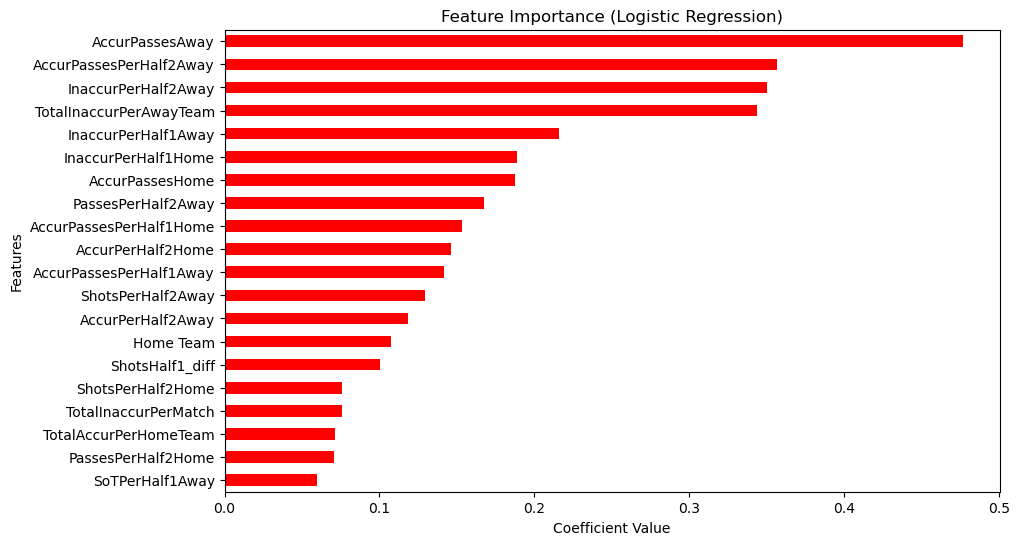

In [24]:
import matplotlib.pyplot as plt

# Get feature importance (model coefficients)
importance = Model.coef_[0]  # Extract the first row since it's a binary classification

# Convert to a Pandas Series for visualization
feature_importance = pd.Series(importance, index=X.columns)  # Ensure matching feature names

# Plot the top 20 important features
plt.figure(figsize=(10, 6))
feature_importance.nlargest(20).plot(kind='barh', color='red', title='Feature Importance (Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()
